# Multi Task Learning

We typically care about optimising for a single, particular metric, for which we generally train a single model or an ensemble of models to perform our desired task. We have seem how we might fine-tune these models in the training process until their performance no longer increases in-sample. While we can generally achieve acceptable performance this way, by being overly focused on our single task, we might not see information that might help us do even better. Specifically, this information comes from the training signals of related tasks. By sharing representations between related tasks, we can enable our model to generalize better on our original task. This approach is called Multi-Task Learning (MTL) and will be the topic of this notebook.

Multi-task learning is a cutting edge area of ML and has been used successfully across all applications of machine learning, from natural language processing, speech recognition, computer vision, and drug discovery. MTL comes in many guises: joint learning, learning to learn, and learning with auxiliary tasks are only some names that have been used to refer to it. As soon as you find yourself optimizing more than one loss function while "parameter sharing", you are effectively doing multi-task learning (in contrast to single-task learning). In those scenarios, it helps to think about what you are trying to do explicitly in terms of MTL and to draw insights from it.

In a finance context, returns are the result we want but they are very noisy with respect to signals from our dataset.
It makes intuitive sense to forecast a proxy variable, even if your forecasting error is lower. It may make even more sense to forecast many proxies as well as the lal important return. This is what we will do in a simple way in this notebook.

Rather than forcast the singular outcome of return, we are going to forecast ROE, separately forecast returns and combine the outcomes of the two learners using a simple trick which implicitly results in parameter sharing...

In [136]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

#Core ML library...
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import os

At the moment we have only been using our models to predict the average return of a company. This means that if we were to use our models to select stocks then we would only be selecting stocks that were predicted to have a good average return. In this section, we will look at creating a multi-objective-learner, and a simple way of achieving parameter sharing for multi-task-learning. 

We will use two separate random forest models, one to forecast returns and the other to predict the return on equity (ROE) of a company. We will use both random forests to select stocks that have a good predicted ROE and a good predicted average returns.

First we need to create a dataset that we can use to train the random forest model to predict the ROE of a company. We will use the december ROE as the independent variable for our model, and use all the same dependent variables as before apart from the variables relating to ROE.

In [137]:
def getRoe(row):
    """
    for a row in X.csv, get the correct December ROE.
    """
    year = row['YEAR']
    ticker = row['TICKER']
    date = str(year) + "-12-31"
    value = roe[roe["TICKER"] == ticker][date].values[0]
    row['AVERAGE RETURN'] = value
    
    if row.name % 1000 == 0:
        print(row.name, end='\r')
    return row

In [138]:
X = pd.read_csv("X.csv")
roe = pd.read_csv("Data/Diag ROE.csv")

# drop the years we are not interested in
for col in roe.columns[4:]:
    year = col[:4]
    if year not in ['2004', '2007', '2010', '2013', '2016', '2019']:
        roe.drop(col, inplace=True, axis=1)
        
X = X.apply(getRoe, axis=1)
X = X.rename(columns={"AVERAGE RETURN" : "END ROE"})
X.head()

,NAME,TICKER,SECTOR,COUNTRY,YEAR,END ROE,Beta_DnSide_24m 12 months prior,Beta_DnSide_24m 24 months prior,Beta_DnSide_24m 36 months prior,Diag DebtToEquity 12 months prior,...,EPS 36 months prior,GroupRank_Diag FreeCashFlowpers 12 months prior,GroupRank_Diag FreeCashFlowpers 24 months prior,GroupRank_Diag FreeCashFlowpers 36 months prior,GroupRank_NPL_Loans_egSector 12 months prior,GroupRank_NPL_Loans_egSector 24 months prior,GroupRank_NPL_Loans_egSector 36 months prior,Mkt_Beta_2yrs 12 months prior,Mkt_Beta_2yrs 24 months prior,Mkt_Beta_2yrs 36 months prior
0,Antofagasta plc,8,Materials,United Kingdom,2019,6.601105,0.466629,0.613881,0.605679,0.000323,...,0.563397,0.716,0.473,0.115,0.0,0.0,0.0,0.733146,0.179791,0.266553
1,Ashtead Group plc,11,Industrials,United Kingdom,2019,29.917032,0.520017,0.599024,0.582105,0.000942,...,0.563424,0.603,0.521,0.105,0.0,0.0,0.0,0.749883,0.180655,0.265154
2,Barratt Developments PLC,16,Consumer Discretionary,United Kingdom,2019,15.657565,0.449442,0.504130,0.479913,0.000225,...,0.563414,0.413,0.386,0.547,0.0,0.0,0.0,0.728778,0.180987,0.258411
3,Bellway p.l.c.,17,Consumer Discretionary,United Kingdom,2019,19.661448,0.460925,0.492347,0.491910,0.000125,...,0.563498,0.000,0.000,0.000,0.0,0.0,0.0,0.728606,0.181924,0.260856
4,Balfour Beatty plc,18,Industrials,United Kingdom,2019,11.931065,0.447137,0.538631,0.540481,0.000915,...,0.563386,0.000,0.000,0.000,0.0,0.0,0.0,0.724920,0.179470,0.257796


Now lets clip the outliers. Again we do not scale the independent variable.

In [139]:
years = list(set(X['YEAR']))

for year in years:      
    X_year = X.loc[X['YEAR'] == year, 'END ROE']
    upperlim = X_year.quantile(0.95)
    lowerlim = X_year.quantile(0.05)
    X_year.clip(lower=lowerlim, upper=upperlim, inplace=True)
    X.loc[X['YEAR'] == year, 'END ROE'] = X_year

Now we split the data into a training and a test set using the same random state as before.

In [77]:
#First the ROE data set
y_roe = X['END ROE']
X = X.drop([
    'END ROE',
    'NAME',
    'TICKER',
    'SECTOR',
    'COUNTRY',
    'YEAR'
], axis=1)
X_train_roe, X_test_roe, y_train_roe, y_test_roe = train_test_split(X, y, test_size=0.33, random_state=30)

#Second, the total return data set
df = pd.read_csv('X.csv')
y = df['AVERAGE RETURN'] # independent variable 

# Drop the non-numeric columns from the dependent variables
X = df.drop(
    ["NAME",
    "TICKER",
    "SECTOR",
    "COUNTRY",
    "YEAR",
    "AVERAGE RETURN"],
axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=30)

Let us plot a histogram of ```y``` to see if ```END ROE``` is normally distributed.

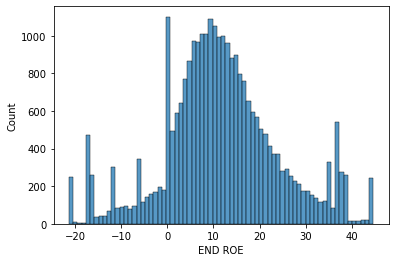

In [78]:
sns.histplot(y_roe);

The ```END ROE``` does not look to be normally distributed. However, since we we are using the model trained to predict ```END ROE``` in conjunction with model the average return this is not as big of an issue. 

Now let us train two new random forest to predict ```END ROE``` and ```AVERAGE RETURN```. We will create a simple class that will allow us to train, test, and use the multiclass learner to predict the best stocks. 

In [151]:
from sklearn.ensemble import RandomForestRegressor

class MultiTaskRandomForest:
    def __init__(self, n_estimators=(50,50), max_depth=(15,15)):
        self.rf_ret = RandomForestRegressor(
            n_estimators = n_estimators[0],
            max_depth = max_depth[0],
            criterion = 'mse'
        )
        
        self.rf_roe = RandomForestRegressor(
            n_estimators = n_estimators[1],
            max_depth = max_depth[1],
            criterion = 'mse'
        )
        
    def fit(self, X_train, y_train_ret, y_train_roe):
        self.rf_ret.fit(X_train, y_train_ret)
        self.rf_roe.fit(X_train, y_train_roe)
        
    def predict(self, X):
        y_hat = (
            self.rf_ret.predict(X),
            self.rf_roe.predict(X)
        )
        return y_hat
        
    def getBestStocks(self, X, q=0.9):
        """
        Select the best stocks in X according to the predidictions of the random forests.
        Stocks are select if their prediction y_hat is greater than the q-th quantile of the
        predictions. This function returns three boolean arrays (True if the stock has
        been selected, and False if it has not). The first array is the union of the stocks
        selected by both random forests. The second array contains the stocks selected by the 
        random forest trained to predict average returns. The third array contains stocks selected
        by the random forest trained to predice ROE.
        """
        y_hat_ret, y_hat_roe = self.predict(X)
        
        lowerlim_ret = pd.Series(y_hat_ret).quantile(q=q)
        lowerlim_roe = pd.Series(y_hat_roe).quantile(q=q)
        
        best_stocks_ret = y_hat_ret > lowerlim_ret # best stocks in terms of predicted average return
        best_stocks_roe = y_hat_roe > lowerlim_roe # best stocks in terms of predicted roe
        best_stocks = best_stocks_ret & best_stocks_roe # union of best_stocks_roe and best_stocks_ret
        
        return best_stocks, best_stocks_ret, best_stocks_roe

Let us train a multi-task random forest.

In [152]:
multi_task_rf = MultiTaskRandomForest()
multi_task_rf.fit(X_train, y_train, y_train_roe)

Let us see how well these stocks actually performed.

In [153]:
best_stocks, best_stocks_ret, best_stocks_roe = multi_task_rf.getBestStocks(X_test)
print(y_test.loc[best_stocks_ret].mean())
print(y_test.loc[best_stocks_roe].mean())
print(y_test.loc[best_stocks].mean())

0.3867590126396047
0.37872382714516056
0.4175993031299297


We can see above that the intersection of stocks selected by the average return and ROE random forests perform better than the stocks selected by each random forest individually. Finally let us look at how many stocks the random forests selected.

In [154]:
print(sum(best_stocks))
print(sum(best_stocks_ret))
print(sum(best_stocks_roe))

621
925
925


## Out of sample 2020 predictions

Now, let us use the multi-task random forest to predict the average returns in 2020. First we have to prepare the data. Let us start by preparing the average returns.

In [155]:
# load the return and index data
df = pd.read_csv("Data/TotalReturn_BaseCCY.csv")
index = pd.read_csv("Index/INDEX.csv", skiprows=8)

# keep only the 2020 data
df = df[df.columns[:13]]
index = index[index.columns[4:13]]
index.columns = df.columns[4:]

# adjust the 2020 using the indexes
df[df.columns[4:]] += 1
df[df.columns[4:]] = df[df.columns[4:]].divide(1 + index.iloc[0], axis=1)
df[df.columns[4:]] -= 1

# drop any rows that contain a missing value
df = df.dropna()

# clip the returns to remove outliers
upperlim = df[df.columns[4:]].quantile(0.95)
lowerlim = df[df.columns[4:]].quantile(0.05)
df[df.columns[4:]] = df[df.columns[4:]].clip(lower=lowerlim, upper=upperlim, axis=1)

# calculate the geometric mean
df["AVERAGE RETURN"] = (df[df.columns[4:]] + 1).product(axis=1) - 1
df = df.drop(upperlim.index, axis=1)
df.head()

,NAME,TICKER,SECTOR,COUNTRY,AVERAGE RETURN
7,Antofagasta plc,8,Materials,United Kingdom,0.173110
10,Ashtead Group plc,11,Industrials,United Kingdom,0.208256
15,Barratt Developments PLC,16,Consumer Discretionary,United Kingdom,-0.348825
16,Bellway p.l.c.,17,Consumer Discretionary,United Kingdom,-0.377606
17,Balfour Beatty plc,18,Industrials,United Kingdom,-0.126351


Now that we have the average returns for 2020, we need to extract the dependent variables for 2020.

In [156]:
files = os.listdir('Data')
files.remove("TotalReturn_BaseCCY.csv")
[files.remove(file) for file in ['EBITDA_SALES.csv', 'OperationalLev_USD.csv', 'Rev_Quality.csv', 'NI_Sales.csv']]

for file in files:
    path = "Data/" + file
    x = pd.read_csv(path)
    x = x[["2019-12-31", "2018-12-31", "2017-12-31"]]
    names = [
        file[:-4] + " 12 months prior",
        file[:-4] + " 24 months prior",
        file[:-4] + " 36 months prior"
    ]
    x.columns = names
    x = x.loc[x.index.isin(df.index)]
    df = df.merge(x, left_index=True, right_index=True, how='left')
df.head()

,NAME,TICKER,SECTOR,COUNTRY,AVERAGE RETURN,Beta_DnSide_24m 12 months prior,Beta_DnSide_24m 24 months prior,Beta_DnSide_24m 36 months prior,Diag DebtToEquity 12 months prior,Diag DebtToEquity 24 months prior,...,EPS 36 months prior,GroupRank_Diag FreeCashFlowpers 12 months prior,GroupRank_Diag FreeCashFlowpers 24 months prior,GroupRank_Diag FreeCashFlowpers 36 months prior,GroupRank_NPL_Loans_egSector 12 months prior,GroupRank_NPL_Loans_egSector 24 months prior,GroupRank_NPL_Loans_egSector 36 months prior,Mkt_Beta_2yrs 12 months prior,Mkt_Beta_2yrs 24 months prior,Mkt_Beta_2yrs 36 months prior
7,Antofagasta plc,8,Materials,United Kingdom,0.173110,0.157351,-0.082644,3.429410,33.900860,37.012188,...,0.108119,0.362,0.716,0.473,0.0,0.0,0.0,1.392552,0.939960,1.264044
10,Ashtead Group plc,11,Industrials,United Kingdom,0.208256,1.711203,1.407220,2.750894,134.179611,108.081047,...,1.300219,0.645,0.603,0.521,0.0,0.0,0.0,2.095626,1.654422,1.401318
15,Barratt Developments PLC,16,Consumer Discretionary,United Kingdom,-0.348825,-0.180225,-0.562285,-1.582904,23.872400,25.876867,...,0.796256,0.265,0.413,0.386,0.0,0.0,0.0,1.122903,0.753498,1.454174
16,Bellway p.l.c.,17,Consumer Discretionary,United Kingdom,-0.377606,0.133461,-0.241832,-2.121066,10.711926,14.288648,...,4.885805,0.000,0.000,0.000,0.0,0.0,0.0,1.159806,0.746176,1.603066
17,Balfour Beatty plc,18,Industrials,United Kingdom,-0.126351,-0.606063,-0.626621,-0.007258,60.923332,105.029587,...,0.000000,0.000,0.000,0.000,0.0,0.0,0.0,0.889224,0.588832,1.212978


Now we clip the data to remove outliers.

In [157]:
upperlim = df[df.columns[5:]].quantile(0.95)
lowerlim = df[df.columns[5:]].quantile(0.05)
df[df.columns[5:]] = df[df.columns[5:]].clip(lower=lowerlim, upper=upperlim, axis=1)

We scale the dependent variables to be between 0 and 1

In [158]:
from sklearn.preprocessing import MinMaxScaler

x = df[df.columns[5:]].values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df[df.columns[5:]] = x_scaled

We impute the missing values use k-nearest neighbours.

In [159]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50) # 50 neighbours was the best we found in the preprocessing notebook
df[df.columns[5:]] = imputer.fit_transform(df[df.columns[5:]])

Finally we split the dependent and independent variables.

In [160]:
X_2020 = df.drop([
    'NAME',
    'TICKER',
    'SECTOR',
    'COUNTRY',
    'AVERAGE RETURN'
], axis=1)

y_2020 = df['AVERAGE RETURN']

Let us use the multi-task random forest selelect the best stocks in 2020.

In [161]:
best_stocks_2020, best_stocks_ret_2020, best_stocks_roe_2020 = multi_task_rf.getBestStocks(X_2020)
print(y_2020.loc[best_stocks_ret_2020].mean())
print(y_2020.loc[best_stocks_roe_2020].mean())
print(y_2020.loc[best_stocks_2020].mean())

-0.07197314728053898
-0.0671374174689921
-0.05600689673743348


These returns are interesting. While all are negative (losing money over the 12months ending Sept 30 2020), the multi-task random forest is superior to both single objective RFs.

2020 was a volatile year, with the overall mean return being negative....

In [162]:
y_2020.mean()

-0.04687470471792516

NB: Quantitative models tend to have a Value bias, because over the long run stocks with lower valuations have tended to outperform. This period of time saw markets punish value stocks, with those names doens by -10% in this index in the 12months ending Sept 30 2020. The random forests did not do too well in 2020, but MTL is likely to be a more stable approach to single objective.... 